# How to generate a digital elevation model (DEM) from a lidar point cloud COPC LAZ file
# Comment générer un modèle numérique d'élévation (MNE) à partir d'un nuage de point lidar en format COPC LAZ

Ce tutoriel donne des exemples permettant de générer un [modèle numérique d'élévation](https://natural-resources.canada.ca/maps-tools-and-publications/satellite-imagery-elevation-data-and-air-photos/elevation-data/24975) à partir d'un nuage de point lidar du produit [Nuages de points lidar - Série CanÉlévation](https://ouvert.canada.ca/data/fr/dataset/7069387e-9986-4297-9f55-0288e9676947). Nous utiliserons principalement la librairie [pdal](https://pdal.io/en/2.8.3/index.html) pour préparer les points et générer la grille matricielle.
Plus spécifiquement, nous allons créer un modèle numérique de terrain. Ce modèle est une grille matricielle dont chaque pixel représente une valeur d'altitude du sol à cet endroit.
La création de ce modèle ce fait en trois étapes distinctes.
1. Lire les points.
2. Filtrer les points pour garder seulement ceux ayant la classe sol (classe 2 et 9)
3. Générer une grille de type raster.

## Les étapes:
* [Importation des modules nécessaires](#Import-the-dependancy-modules)
* [Définition des variables](#Define-the-variables)
* [Définition des méthodes](#Define-the-methods)
* [Filtrer les points en préparation à la création du MNE](#Filter-the-points-for-DEM-creation)
* [Création du modèle numérique de terrain en format Geotiff](#Digital-terrain-model-generation-in-Geotiff-format)

## Install/activate the conda environment
## Préparation de l'environnement
Deux étapes sont nécessaires afin de pouvoir exécuter ces exemples localement.
1. Récupération du code source
   À l'endroit de votre choix sur votre ordinateur. Récupérer le code source des exemples en effectuant une commande de clone git.

   ```
   git clone https://github.com/NRCan/CanElevation.git
   ```
   Aller ensuite dans le répertoire contenant les notebooks.

   ```
   cd CanElevation/pointclouds_nuagespoints
   ```

2. Préparation de l'environnement conda

   Nous recommandons l'utilisation de conda pour l'installation des dépendances nécessaires au bon fonctionnement. Des [instructions d'installation détaillées](https://docs.anaconda.com/miniconda/install/#quick-command-line-install) sont disponibles. Les prochaines instructions assument que conda est disponible en ligne de commande.

3. Installation des dépendances

   Le fichier requirements.yaml contient les dépendances nécessaires. Nous devons donc créer un environnement conda avec ces dépendances.

   ```
   conda env create -n CanElevation_PointClouds --file requirements.yml
   ```

   On doit ensuite activer cet environnement conda nouvellement créée. 
	
   ```
   conda activate CanElevation_PointClouds
   ```
    
Le lancement de jupyter notebook peut se faire simplement avec la commande suivante:

    ```
    jupyter notebook
    ```
En cas de problème ou pour plus d'options de lancement, veuillez vous référer au [guide d'utilisation](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/execute.html).

** Vous pouvez maintenant lancer le code de ce notebook **

## Import the dependancy modules
## Importation des modules nécessaires
La création du modèle nécessite l'utilisation de certains modules tels que pdal. De plus, pour des fins de visualisation, nous utiliserons également le librairie [matplotlib](https://matplotlib.org/stable/) ainsi que [rasterio](https://rasterio.readthedocs.io/en/stable/index.html). Ce code sert à les rendre disponibles.

In [1]:
import os
import json
import pdal
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Define the variables
## Définition des variables
Pour la démonstration, nous utiliserons unte tuile lidar spécifique de la région de Niagara en Ontario. Afin de d'alléger le traitement, nous définissons un polygone englobant à l'intérieur de cette tuile.
Ces variables peuvent être ajusté au besoin. Les index des [projets](https://download-telecharger.services.geo.ca/pub/elevation/pointclouds_nuagespoints/Index_LiDARprojects_projetslidar.zip) et des [tuiles](https://download-telecharger.services.geo.ca/pub/elevation/pointclouds_nuagespoints/Index_LiDARtiles_tuileslidar.zip) du produit peuvent être utiles afin de sélectionner une autre zone d'intérêt.

In [2]:
copc_laz = "https://download-telecharger.services.geo.ca/pub/elevation/pointclouds_nuagespoints/NRCAN/Hamilton_Niagara_2021_2/ON_Niagara_20210525_NAD83CSRS_UTM17N_1km_E656_N4771_CLASS.copc.laz"
all_points_laz = "niagara_unfiltered_points.laz"
ground_laz = "niagara_ground_points.laz"
aoi_bbox = {'minx': 656083, 'miny': 4771150, 'maxx': 656722, 'maxy': 4771614}

## Define the methods
## Définition des méthodes
Nous définissons ici quelques méthodes qui serviront à traiter les données. Chaque méthode contient en entête une description décrivant son utilité.

In [3]:

def get_classification_name(code):
    """
    Retrieve standard LiDAR classification names from the code.
    Récupération du nom de la classe lidar à partir de son code.
    
    Args:
        code (int): Classification code
    
    Returns:
        str: Classification name
    """
    classification_names = {
        0: "Created, never classified",
        1: "Unclassified",
        2: "Ground",
        3: "Low Vegetation",
        4: "Medium Vegetation",
        5: "High Vegetation",
        6: "Building",
        7: "Low Point (noise)",
        8: "Model Key-point",
        9: "Water",
        10: "Rail",
        # Add more if needed
    }
    return classification_names.get(code, f"Unknown ({code})")

def get_custom_color(class_code):
    """
    Provide custom colors for specific classification codes.
    
    Définitions de code de couleur spécifique pour certains codes de classification.
    
    Args:
        class_code (int): Classification code
    
    Returns:
        tuple: RGBA color
    """
    custom_colors = {
        1: (0.5, 0.9, 0.5, 0.5),  # Light green
        2: (0.8, 0.4, 0.0, 0.5),  # Dark orange
        6: (1.0, 0, 0, 0.5) # Red
    }
    return custom_colors.get(class_code, None)

def create_read_pdal_pipeline(input_file, output_file, classes = None, bbox = None):
    """
    Create a PDAL pipeline to filter points by classification and bounding box. The pipeline execution will
    transform the resulting point cloud to a digital elevation model (dem) raster.
    
    Création d'un pipeline PDAL servant à filtrer les points selon leur classes et aussi spatialement
    en passant un polygone englobant en paramètre. L'exécution du pipeline transforme le nuage de point résultant
    en grille matriciel représentant un modèle numérique d'élévation (mne)
    
    Args:
        input_file (str): Path to the input point cloud file
        output_file (str): Path to save the filtered point cloud
        classes (list): List of classification to keep
        bbox (dict): Bounding box with min/max coordinates
    
    Returns:
        pdal.Pipeline: Configured PDAL pipeline
    """
    pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": input_file
            }
        ]
    }
    
    # Crop the points using the bbox if provided
    if bbox:
        pipeline_json['pipeline'].append({
                "type": "filters.crop",
                "bounds": f"([{bbox['minx']},{bbox['maxx']}],[{bbox['miny']},{bbox['maxy']}])"
            })
    # keep only the points matching the classification codes pro
    if classes:
        expression = ''
        for class_code in classes:
            if expression:
                expression += f' || Classification == {class_code}'
            else:
                expression = f'Classification == {class_code}'
        
        pipeline_json['pipeline'].append({
                "type":"filters.expression",
                "expression":expression
            })
    
    #Add the writer step
    pipeline_json['pipeline'].append({
                "type": "writers.las",
                "filename": output_file
            })
    
    return pdal.Pipeline(json.dumps(pipeline_json))

def create_dem_pipeline(input_array, output_filename="dem.tif", resolution=1.0, 
                       window_size=6, output_type="mean"):
    """Creates a PDAL pipeline that generates a DEM from an array of points.
    
    Args:
        input_array (numpy.ndarray): Input point cloud array
        output_filename (str, optional): Output DEM filename. Defaults to "dem.tif".
        resolution (float, optional): Output raster resolution in same units as input data. 
            Defaults to 1.0.
        window_size (int, optional): Number of pixels to consider when applying the 
            output_type. Defaults to 6.
        output_type (str, optional): Statistic to use when creating the raster. Can be 
            'mean', 'min', 'max', 'idw', etc. Defaults to "mean".
    
    Returns:
        pdal.Pipeline: Configured PDAL pipeline object ready to execute
    """
    
    # Define the pipeline stages
    pipeline_def = {
        "pipeline": [
            {
                "type": "writers.gdal",
                "filename": output_filename,
                "output_type": output_type,
                "gdaldriver": "GTiff",
                "resolution": resolution,
                "window_size": window_size,
                "gdalopts": "COMPRESS=DEFLATE,PREDICTOR=2,TILED=YES",
                "nodata": -9999
            }
        ]
    }
    
    # Create pipeline and pass the input array directly
    return pdal.Pipeline(json.dumps(pipeline_def), arrays=[input_array])

def create_plot(title, pts_array, max_points = 25000):
    """
    Create a matplotlib.pyplot object that plot the points using a 3 axes graphic. Every point is colorize by mapping
    the classification code to a distinct color.
    
    Args:
        title (str): Title for the plot
        pts_array (numpy.array): Points numpy array obtained from PDAL
        max_points (int): Maximum number of points to keep for the plot
    
    Returns:
        matplotlib.pyplot: Configured plot object
    """
    if len(pts_array) > max_points:
        indices = np.random.choice(len(pts_array), max_points, replace=False)
        pts_array = pts_array[indices]

    # Extract coordinates and classifications
    x = pts_array['X']
    y = pts_array['Y']
    z = pts_array['Z']
    classifications = pts_array['Classification']
    
    # Create color map
    unique_classes = np.unique(classifications)
    color_map = plt.get_cmap('tab10')
    
    # Create 3D scatter plot
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points for each unique classification
    legend_labels = []
    legend_handles = []
    for class_code in unique_classes:
        mask = classifications == class_code
    
        #Use custom color if define, radom color otherwise
        color = get_custom_color(class_code)
        if not color:
            color = color_map(class_code / max(unique_classes))
        
        scatter = ax.scatter(
            x[mask], y[mask], z[mask], 
            c=[color], alpha=0.5, s=5, 
            label=get_classification_name(class_code)
        )
        legend_handles.append(scatter)
        legend_labels.append(get_classification_name(class_code))
    
    # Customize plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    #ax.set_title('Point Cloud Colored by Classification')
    
    # Add legend
    ax.legend(legend_handles, legend_labels, 
              title='Classification', 
              loc='center left', 
              bbox_to_anchor=(1.1, 0.5))
    
    plt.tight_layout()
    return plt
    
def plot_dem(dem_file, figsize=(10, 8), cmap='terrain', vmin=None, vmax=None):
    """Plots a DEM using matplotlib pyplot with proper elevation range handling.
    
    Args:
        dem_file (str): Path to the DEM file (GeoTIFF)
        figsize (tuple, optional): Figure size in inches (width, height). 
            Defaults to (10, 8).
        cmap (str, optional): Colormap to use for visualization. 
            Defaults to 'terrain'.
        vmin (float, optional): Minimum elevation value for color scaling.
            If None, uses data minimum. Defaults to None.
        vmax (float, optional): Maximum elevation value for color scaling.
            If None, uses data maximum. Defaults to None.
    
    Returns:
        tuple: Figure and axis objects from pyplot
    """
    # Read the DEM
    with rasterio.open(dem_file) as src:
        elevation = src.read(1)
        nodata = src.nodata
        
        # Remove NoData values (usually very negative values)
        elevation = np.ma.masked_where(elevation == nodata, elevation)
        
        # If vmin/vmax not provided, calculate from data
        if vmin is None:
            #vmin = np.nanmin(elevation)
            vmin = 75
        if vmax is None:
            vmax = np.nanmax(elevation)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the plot with specified value range
    im = ax.imshow(elevation, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add a colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Elevation')
    
    # Add min/max information to title
    ax.set_title(f'Digital Elevation Model\nElevation range: {vmin:.2f} to {vmax:.2f}')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    
    return fig, ax


Exemple de chargement d'un script dans la cellule

In [4]:
# %load reusable_methods_test.py
def get_custom_color(class_code):
    """
    Provide custom colors for specific classification codes. blabla
    
    Définitions de code de couleur spécifique pour certains codes de classification.
    
    Args:
        class_code (int): Classification code
    
    Returns:
        tuple: RGBA color
    """
    custom_colors = {
        1: (0.5, 0.9, 0.5, 0.5),  # Light green
        2: (0.8, 0.4, 0.0, 0.5),  # Dark orange
        6: (1.0, 0, 0, 0.5) # Red
    }
    return custom_colors.get(class_code, None)

<a id="filter-points"></a>
## Filter the points for DEM creation
## Filtrer les points en préparation à la création du MNE

Pour la préparation du modèle de terrain, nous désirons garder seulement les points représentant la surface. Il faut donc filtrer les points en fonction de leur classification. Nous garderons donc les points classée sol (6) ainsi que les points classés eau (9).
Afin d'illustrer le résultat du filtrage, nous allons utiliser la méthode create_pdal_pipeline pour obtenir deux versions du nuage de points. La première version conservera toutes les classes de points et la seconde, seulement les points qui nous utiliserons pour la création d'un modèle numérique de terrain.
Des graphiques montrant la répartition des points dans l'espace sont ensuite créé afin de bien représenter le résultat du filtrage.

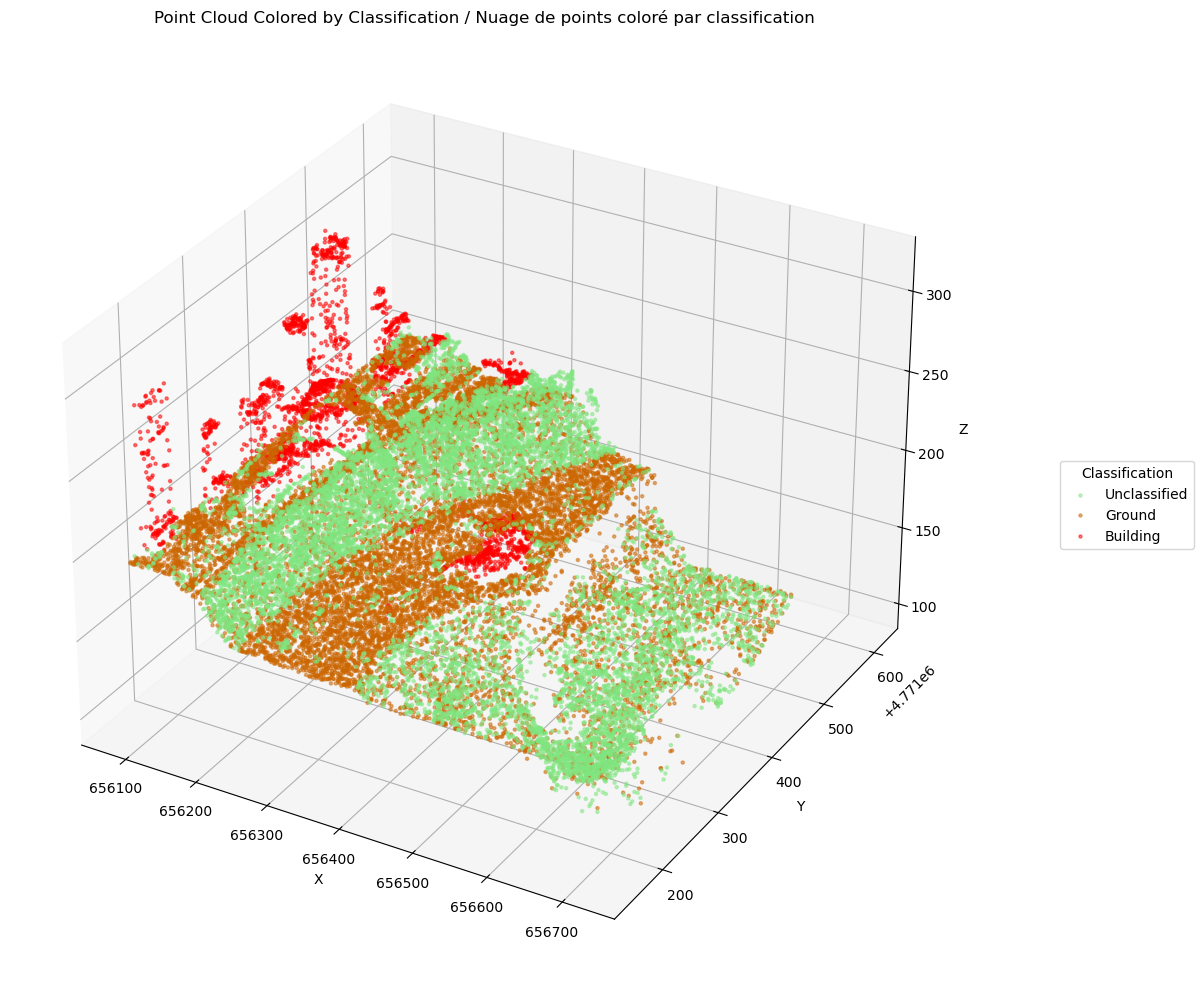

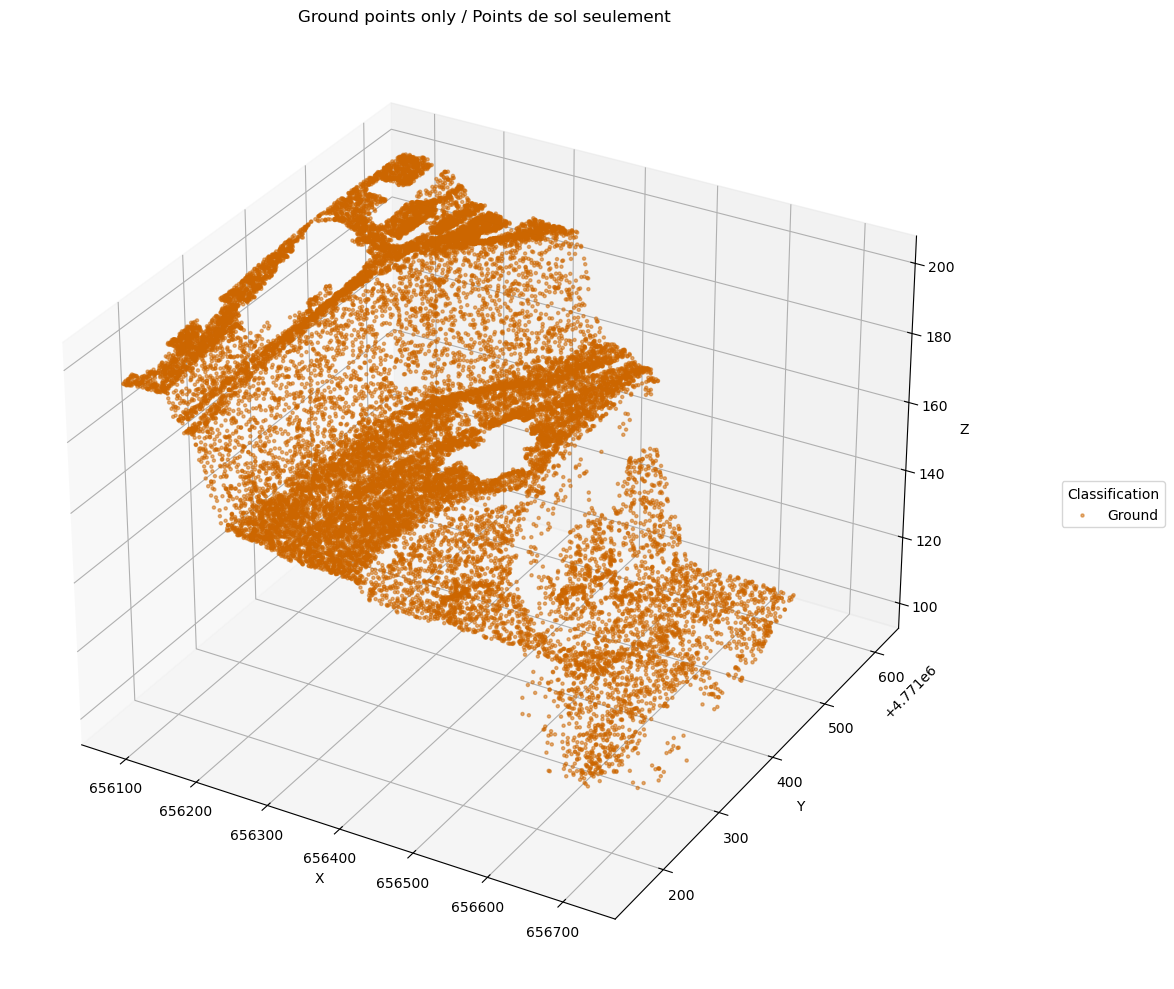

In [5]:
# Keep the points for classes unclassified, ground, buildings, water
pipeline_allpoints = create_read_pdal_pipeline(copc_laz, all_points_laz, bbox = aoi_bbox, classes = [1, 2, 6, 9])
pipeline_allpoints.execute()
points = pipeline_allpoints.arrays[0]
plot1 = create_plot('Point Cloud Colored by Classification / Nuage de points coloré par classification', points, max_points = 25000)
plot1.show()

#Keep ground and water points for dem creation
pipeline_ground_points = create_read_pdal_pipeline(copc_laz, ground_laz, bbox = aoi_bbox, classes = [2, 9])
pipeline_ground_points.execute()
ground_points = pipeline_ground_points.arrays[0]
plot2 = create_plot('Ground points only / Points de sol seulement', ground_points, max_points = 25000)
plot2.show()

## Digital terrain model generation in Geotiff format
## Création du modèle numérique de terrain en format Geotiff
Pour cette étape, nous utilisons l'objet ground_points conterant le vecteur des points et nous le passons à la méthode create_dem_pipeline. Celle-ci genère un pipeline permettant de transformer ces points en format matriciel. Afin d'illustrer le résultat de l'opération, un nouveau graphique est produit.
Le résultat contient des zones sans données (NoData). L'absence de points représentant la surface explique la présence de ces zones. Pour les applications nécessitant une couverture complète de données, il est possible d'utiliser un utilitaire de remplissage de ces zones tel que l'outils [gdal_fillnodata](https://gdal.org/en/stable/programs/gdal_fillnodata.html).


In [1]:
dem_pipeline = create_dem_pipeline(ground_points)
dem_pipeline.execute()
fig, ax = plot_dem('dem.tif', cmap = 'gist_earth')
plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'create_dem_pipeline' is not defined